# Figure 3: Robustness of transitional policy failure

This notebook reproduces **Figure 3** in the paper  
*“Asynchronous Implementation of the Travel Rule and Transitional Risks in Crypto-Asset Regulation.”*

## Purpose
The notebook conducts robustness analyses to verify that the transitional effects identified in Figure 2 do not depend on a specific parameter configuration.

Two dimensions are examined:
- **Adoption timing asymmetry**: varying the delay in Travel Rule adoption by lagging jurisdictions  
- **Implementation capacity**: varying the speed of post-adoption implementation in lagging jurisdictions

## Output
Running all cells generates `Figure3.png`, corresponding exactly to Figure 3 in the paper.  
The vertical axis reports the difference in mean illicit activity during the transition period relative to the synchronized adoption scenario.

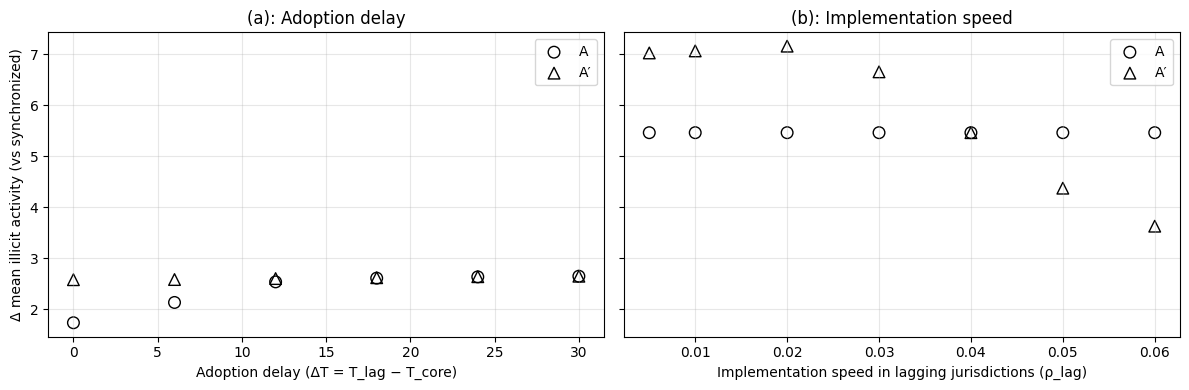

In [1]:
# ============================================
# Figure 3: Robustness of transitional failure
# Final submission-ready version
# ============================================

import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Scenario parameters
# ----------------------------
def scenario_params(scenario):
    if scenario == "S":
        Tj = np.array([6, 6, 6, 6, 6, 6])
        rho = np.array([0.06, 0.06, 0.05, 0.05, 0.04, 0.04])
    elif scenario == "A":
        Tj = np.array([6, 6, 18, 18, 36, 36])
        rho = np.array([0.06, 0.06, 0.05, 0.05, 0.04, 0.04])
    elif scenario == "Aprime":
        Tj = np.array([6, 6, 18, 18, 36, 36])
        rho = np.array([0.06, 0.06, 0.05, 0.05, 0.015, 0.015])
    else:
        raise ValueError("Unknown scenario")
    return Tj, rho


# ----------------------------
# Core ABM (minimal: Y only)
# ----------------------------
def run_one(
    scenario,
    seed,
    *,
    T=60,
    N=100,
    Tj_override=None,
    rho_override=None,
):
    rng = np.random.default_rng(seed)

    Tj, rho = scenario_params(scenario)
    if Tj_override is not None:
        Tj = np.array(Tj_override, dtype=int)
    if rho_override is not None:
        rho = np.array(rho_override, dtype=float)

    J = 6
    L = np.zeros(J)
    R = np.zeros(J)
    Y = np.zeros(T)

    for t in range(T):
        for j in range(J):
            if t >= Tj[j]:
                L[j] = 1
                R[j] = min(1.0, R[j] + rho[j])

        # sunrise gap (parsimonious)
        s_gap = 1.0 - np.mean(L * R)

        pA = np.clip(0.18 - 0.4 * s_gap, 0, 1)
        pB = np.clip(0.08 - 0.5 * s_gap, 0, 1)
        pC = 0.02

        costA, costB, costC = pA * 6 + 0.2, pB * 6 + 0.05, pC * 6 + 0.8
        probs = np.exp(-5 * np.array([costA, costB, costC]))
        probs /= probs.sum()

        choices = rng.choice([0, 1, 2], size=N, p=probs)
        caught = rng.random(N) < np.where(
            choices == 0, pA, np.where(choices == 1, pB, pC)
        )

        Y[t] = N - caught.sum()

    return Y


# ----------------------------
# Transitional mean Y
# ----------------------------
def transitional_mean_Y(
    scenario,
    *,
    Rruns,
    t1=6,
    t2=35,
    Tj_override=None,
    rho_override=None,
    seed0=100000,
):
    vals = []
    for r in range(Rruns):
        Y = run_one(
            scenario,
            seed=seed0 + r,
            Tj_override=Tj_override,
            rho_override=rho_override,
        )
        vals.append(Y[t1 : t2 + 1].mean())
    return np.mean(vals)


# ----------------------------
# Figure 3
# ----------------------------
def make_figure3(
    *,
    Rruns=200,
    # Panel-specific averaging windows
    # Panel (a): pre-lag window (baseline lag adoption is at t=36)
    t1_a=6,
    t2_a=35,
    # Panel (b): post-lag window to capture implementation-speed effects
    t1_b=36,
    t2_b=59,
    deltaT_grid=(0, 6, 12, 18, 24, 30),
    rho_lag_grid=(0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06),
    # Common-random-number seeds (panel-specific)
    seed_panel_a=200000,
    seed_panel_b=300000,
    savepath="Figure3.png",
):
    # Baseline (synchronized) computed using the same random streams as each panel
    YS_a = transitional_mean_Y("S", Rruns=Rruns, t1=t1_a, t2=t2_a, seed0=seed_panel_a)
    YS_b = transitional_mean_Y("S", Rruns=Rruns, t1=t1_b, t2=t2_b, seed0=seed_panel_b)

    base_Tj_A, base_rho_A = scenario_params("A")
    base_Tj_Ap, base_rho_Ap = scenario_params("Aprime")

    # ---- Panel (a): Adoption delay (vary T_lag, hold T_mid fixed) ----
    YA, YAp = [], []
    for dT in deltaT_grid:
        TjA = base_Tj_A.copy()
        TjA[4:] = TjA[0] + dT

        TjAp = base_Tj_Ap.copy()
        TjAp[4:] = TjAp[0] + dT

        YA.append(
            transitional_mean_Y(
                "A",
                Rruns=Rruns,
                t1=t1_a,
                t2=t2_a,
                Tj_override=TjA,
                rho_override=base_rho_A,
                seed0=seed_panel_a,
            ) - YS_a
        )
        YAp.append(
            transitional_mean_Y(
                "Aprime",
                Rruns=Rruns,
                t1=t1_a,
                t2=t2_a,
                Tj_override=TjAp,
                rho_override=base_rho_Ap,
                seed0=seed_panel_a,
            ) - YS_a
        )

    # ---- Panel (b): Implementation speed (vary rho_lag only for A′; keep A at baseline) ----
    # A: keep baseline implementation speeds (normal implementation)
    YA_const = (
        transitional_mean_Y(
            "A",
            Rruns=Rruns,
            t1=t1_b,
            t2=t2_b,
            Tj_override=base_Tj_A,
            rho_override=base_rho_A,
            seed0=seed_panel_b,
        )
        - YS_b
    )
    YA_rho = [YA_const] * len(rho_lag_grid)

    # A′: vary implementation speed in lagging jurisdictions (paper compliance → improved)
    YAp_rho = []
    for rl in rho_lag_grid:
        rhoAp = base_rho_Ap.copy()
        rhoAp[4:] = rl  # vary only lagging jurisdictions
        YAp_rho.append(
            transitional_mean_Y(
                "Aprime",
                Rruns=Rruns,
                t1=t1_b,
                t2=t2_b,
                Tj_override=base_Tj_Ap,
                rho_override=rhoAp,
                seed0=seed_panel_b,
            )
            - YS_b
        )


    # ---- Plot ----
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    # Panel (a): ○ and △
    axs[0].scatter(
        deltaT_grid, YA,
        label="A",
        marker="o",
        facecolors="none",
        edgecolors="black",
        s=70,
    )
    axs[0].scatter(
        deltaT_grid, YAp,
        label="A′",
        marker="^",
        facecolors="none",
        edgecolors="black",
        s=70,
    )
    axs[0].set_xlabel("Adoption delay (ΔT = T_lag − T_core)")
    axs[0].set_ylabel("Δ mean illicit activity (vs synchronized)")
    axs[0].set_title("(a): Adoption delay")
    axs[0].legend()
    axs[0].grid(alpha=0.3)

    # Panel (b): ○ and △
    axs[1].scatter(
        rho_lag_grid, YA_rho,
        label="A",
        marker="o",
        facecolors="none",
        edgecolors="black",
        s=70,
    )
    axs[1].scatter(
        rho_lag_grid, YAp_rho,
        label="A′",
        marker="^",
        facecolors="none",
        edgecolors="black",
        s=70,
    )
    axs[1].set_xlabel("Implementation speed in lagging jurisdictions (ρ_lag)")
    axs[1].set_title("(b): Implementation speed")
    axs[1].legend()
    axs[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(savepath, dpi=200)
    plt.show()


# ----------------------------
# Run
# ----------------------------
if __name__ == "__main__":
    make_figure3()